In [1]:
import pandas as pd


C:\Users\voqua\AppData\Local\Temp\ipykernel_35056\2035458946.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Default unit cost, very efficient HD
myDF = pd.read_csv("../dataset/placementDecisions_rl_los_cost_2.csv")

In [3]:
myDF.columns

Index(['Unnamed: 0', 'ocp_jl', 'ocp_wr', 'ocp_hd', 'class_mild', 'need',
       'placement', 'ocp_jl_low_los', 'ocp_jl_total', 'ocp_wr_low_los',
       'ocp_wr_total', 'ocp_hd_low_los', 'ocp_hd_total'],
      dtype='object')

In [4]:
myDF.drop(["Unnamed: 0", "ocp_jl", "ocp_wr", "ocp_hd"], inplace= True, axis = 1)

In [5]:
# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in myDF.iterrows():
    if item['placement'] == 'work release':
        myDF['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        myDF['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        myDF['placement'].iat[ind] = '2'

#object to int
myDF['placement'] = pd.to_numeric(myDF['placement'])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [8]:
y = myDF["placement"]
X = myDF.drop(["placement"], axis = 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size = 0.7, random_state = 50)

## A random model acting as a baseline for performance comparison

In [10]:
rf2 = RandomForestClassifier(random_state= 50)
rf2.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score 

In [12]:
y_pred = rf2.predict(X_test)
print('f1_score' + str(f1_score(y_test, y_pred, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_pred, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_pred, average ='weighted')))

f1_score0.7730078117610647
precision_score: 0.7728433627990481
recall_score: 0.7732420331840927


In [13]:
rf2.feature_names_in_ #ocp_wr_total (0.557), need (0.125)

array(['class_mild', 'need', 'ocp_jl_low_los', 'ocp_jl_total',
       'ocp_wr_low_los', 'ocp_wr_total', 'ocp_hd_low_los', 'ocp_hd_total'],
      dtype=object)

In [14]:
rf2.feature_importances_

array([0.03121749, 0.12469477, 0.05278501, 0.06089935, 0.0631285 ,
       0.55667692, 0.05271321, 0.05788474])

In [15]:
indexes = [ 1893, 3897, 6155, 1692, 2114, 3090, 4098, 6100, 8726]

same_shap = {}
for val in indexes:
    same_shap[val] = [X_train.iloc[val]]

same_shap

{1893: [class_mild          0.0
  need                0.0
  ocp_jl_low_los    193.0
  ocp_jl_total      433.0
  ocp_wr_low_los     75.0
  ocp_wr_total      145.0
  ocp_hd_low_los    254.0
  ocp_hd_total      484.0
  Name: 6340, dtype: float64],
 3897: [class_mild          1.0
  need                0.0
  ocp_jl_low_los    246.0
  ocp_jl_total      460.0
  ocp_wr_low_los     63.0
  ocp_wr_total      143.0
  ocp_hd_low_los    248.0
  ocp_hd_total      503.0
  Name: 8490, dtype: float64],
 6155: [class_mild          0.0
  need                0.0
  ocp_jl_low_los    193.0
  ocp_jl_total      433.0
  ocp_wr_low_los     75.0
  ocp_wr_total      145.0
  ocp_hd_low_los    254.0
  ocp_hd_total      484.0
  Name: 6339, dtype: float64],
 1692: [class_mild          1.0
  need                1.0
  ocp_jl_low_los    218.0
  ocp_jl_total      391.0
  ocp_wr_low_los     73.0
  ocp_wr_total      144.0
  ocp_hd_low_los    222.0
  ocp_hd_total      430.0
  Name: 3325, dtype: float64],
 2114: [class_mild  

In [13]:
#Optimize models

In [15]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [16]:
param_grid = {'n_estimators': [100,150,200, 230], 'max_depth': [None, 5, 10], 
              'min_samples_leaf': [2, 5, 10],
              'min_samples_split': [2, 4, 6], 'max_features': ["sqrt", "log2", None]}

In [21]:
sh = HalvingGridSearchCV(rf2, param_grid, cv = 5, factor = 2, random_state=50).fit(X_train, y_train)

In [22]:
sh.best_params_

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 230}

In [23]:
rf2a = RandomForestClassifier(max_depth= 5, max_features = None, min_samples_leaf = 5,
 min_samples_split = 6, n_estimators = 230, random_state= 50)

In [24]:
rf2a.fit(X_train, y_train)
y_preda = rf2a.predict(X_test)
print('f1_score:' + str(f1_score(y_test, y_preda, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_preda, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_preda, average ='weighted')))

f1_score:0.8061518455813604
precision_score: 0.8060477243153719
recall_score: 0.8064261258888596


In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf2a.predict_proba(X_test), multi_class='ovr' )

0.9205729823186463

## Applying Cross Validation to the model

In [31]:
rf2a_0 = RandomForestClassifier(max_depth= 5, max_features = None, min_samples_leaf = 5,
 min_samples_split = 6, n_estimators = 230, random_state= 50)
placement_0 = y_test.copy()
placement_0[placement_0 == 0] = 3
placement_0[(placement_0 == 1) | (placement_0 == 2)] = 0
placement_0[placement_0 == 3] = 1
from sklearn.model_selection import cross_validate
cv_results_0 = cross_validate(rf2a_0, X_test, placement_0, cv = 3, scoring = 'roc_auc')
cv_results_0 

{'fit_time': array([0.60679674, 0.66000223, 0.55478883]),
 'score_time': array([0.01755428, 0.01524401, 0.01700091]),
 'test_score': array([1.        , 0.99997372, 0.99996279])}

In [28]:
# placement 0 is Home Detention
placement_0.value_counts()

placement
0    2733
1    1064
Name: count, dtype: int64

In [32]:
# placement 1 is Work Release
rf2a_1 = RandomForestClassifier(max_depth= 5, max_features = None, min_samples_leaf = 5,
 min_samples_split = 6, n_estimators = 230, random_state= 50)
placement_1 = y_test.copy()
placement_1[ placement_1 != 1] = 0
from sklearn.model_selection import cross_validate
cv_results_1 = cross_validate(rf2a, X_test, placement_1, cv = 3, scoring = 'roc_auc')
cv_results_1

{'fit_time': array([1.11847782, 1.070544  , 1.13540649]),
 'score_time': array([0.03024745, 0.02600002, 0.0250001 ]),
 'test_score': array([0.87570911, 0.86567985, 0.88663337])}

In [33]:
# placement 3 is Jail
rf2a_2 = RandomForestClassifier(max_depth= 5, max_features = None, min_samples_leaf = 5,
 min_samples_split = 6, n_estimators = 230, random_state= 50)
placement_2 = y_test.copy()
placement_2[placement_2 == 1] = 0
placement_2[placement_2 == 2] = 1

from sklearn.model_selection import cross_validate
cv_results_2 = cross_validate(rf2a_2, X_test, placement_2, cv = 3, scoring = 'roc_auc')
cv_results_2

{'fit_time': array([1.11072803, 1.10417986, 1.03954577]),
 'score_time': array([0.06705666, 0.02596521, 0.02653217]),
 'test_score': array([0.87787428, 0.86747994, 0.88090925])}

## SHAP LIBRARY - DATA INTERPRETATION

In [18]:
import shap

c:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
explainer2 = shap.TreeExplainer(rf2a)
shap_values2 = explainer2(X_train)

In [17]:
rf2.classes_ #work release, home detention, jail

array([0, 1, 2], dtype=int64)

In [66]:
pd2_wr = pd.DataFrame(shap_values2[:,:,0].values, columns=rf2a.feature_names_in_)
pd2_hd = pd.DataFrame(shap_values2[:,:,1].values, columns=rf2a.feature_names_in_)
pd2_jl = pd.DataFrame(shap_values2[:,:,2].values, columns=rf2a.feature_names_in_)

In [67]:
pd2_wr.to_csv("pd2_wr_tuned.csv", index = False)
pd2_hd.to_csv("pd2_hd_tuned.csv", index = False)
pd2_jl.to_csv("pd2_jl_tuned.csv", index = False)

In [19]:
shap.initjs()

In [42]:
shap_value_wr = shap_values2[:,:,0]
shap_value_hd = shap_values2[:,:,1]
shap_value_jl = shap_values2[:,:,2]

In [43]:
(shap_value_wr).shape

(8859, 8)

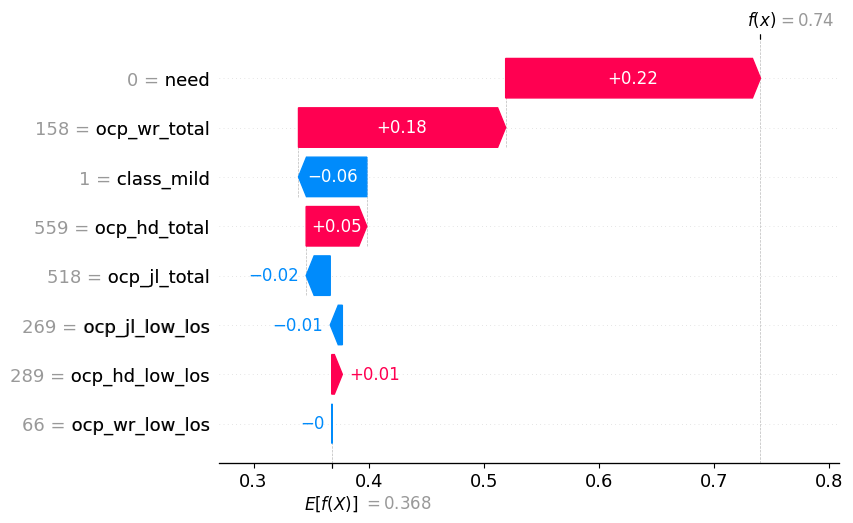

In [44]:
shap.plots.waterfall(shap_value_jl[1])

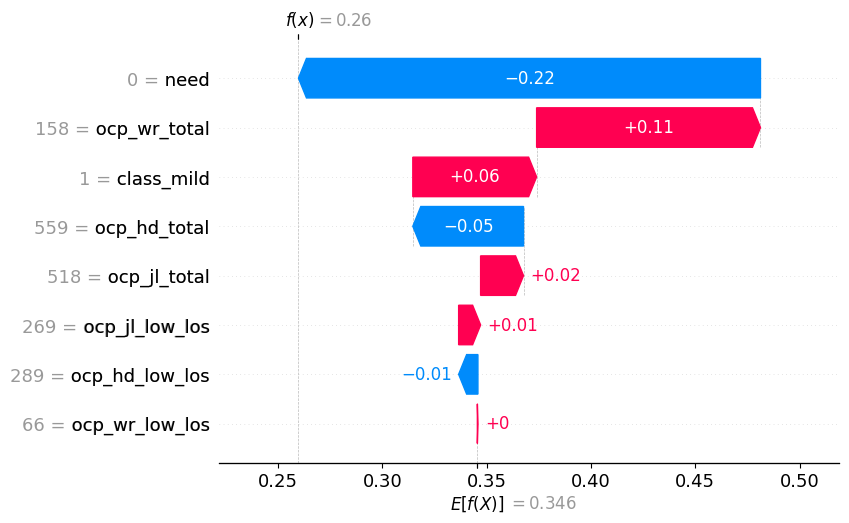

In [46]:
shap.plots.waterfall(shap_value_hd[1])

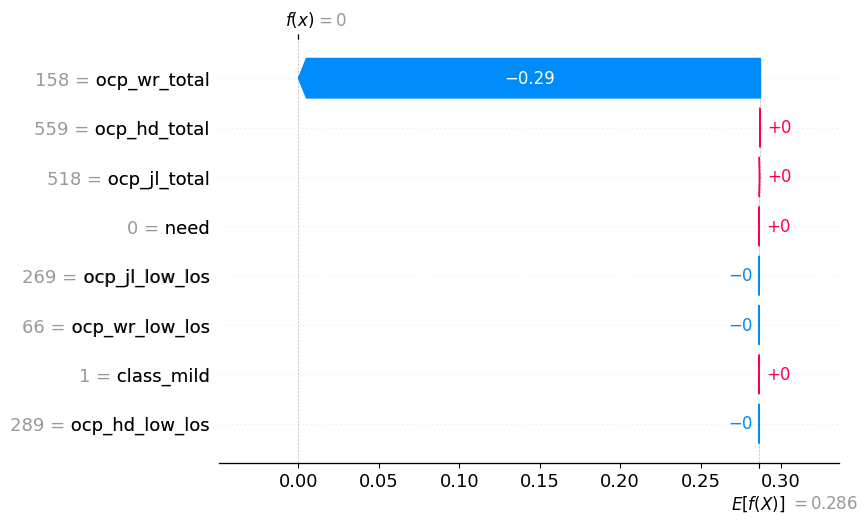

In [45]:
shap.plots.waterfall(shap_value_wr[1])

In [20]:
shap_values2.shape

(8859, 8, 3)

Home Detention

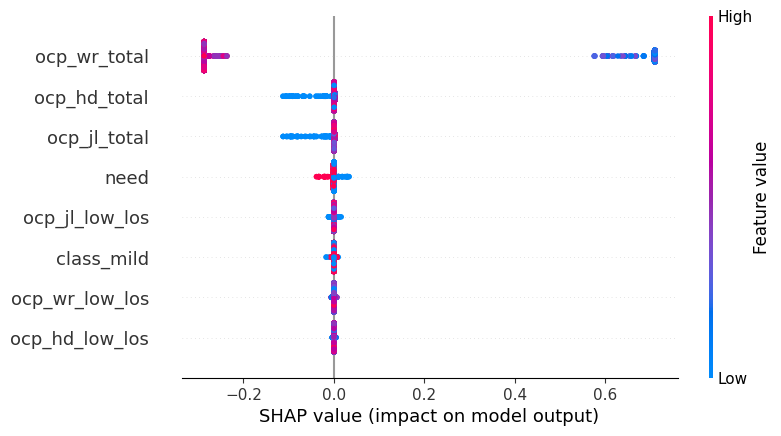

In [26]:
#tuned
shap.plots.beeswarm(shap_values2[:,:,0])

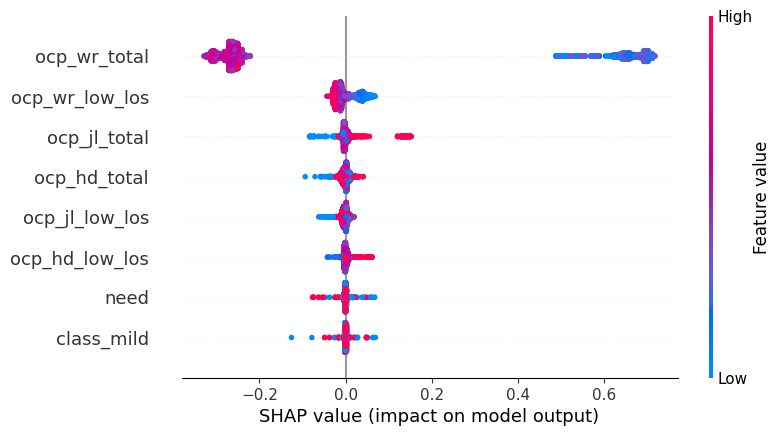

In [19]:
#pre_tuned
shap.plots.beeswarm(shap_values2[:,:,0])

Work Release

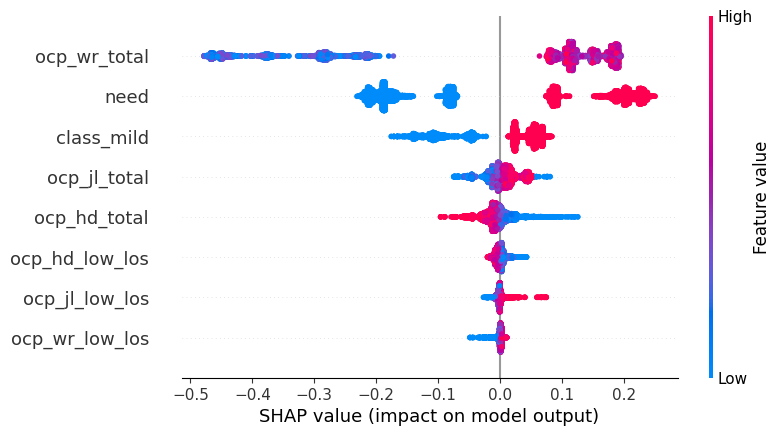

In [27]:
#tuned
shap.plots.beeswarm(shap_values2[:,:,1])

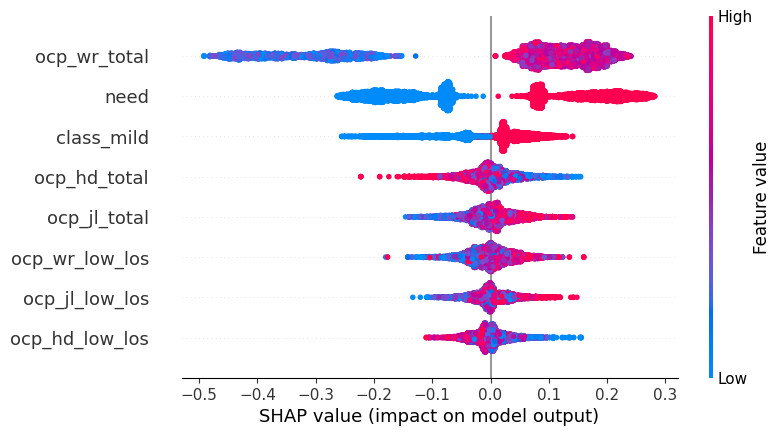

In [20]:
#pre_tuned
shap.plots.beeswarm(shap_values2[:,:,1])

Jail

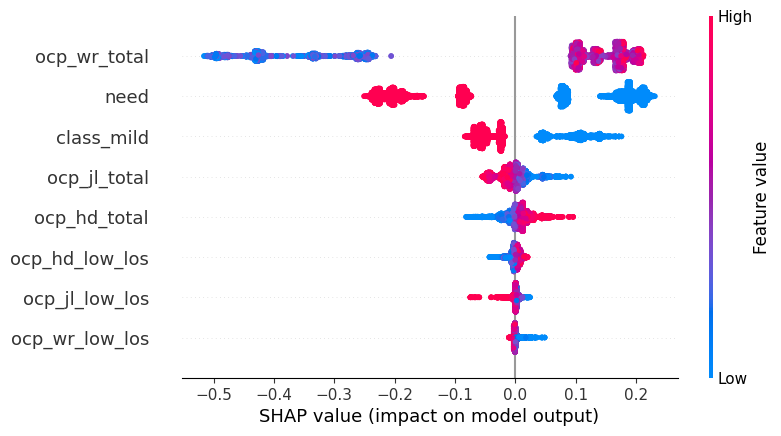

In [28]:
#tuned
shap.plots.beeswarm(shap_values2[:,:,2])

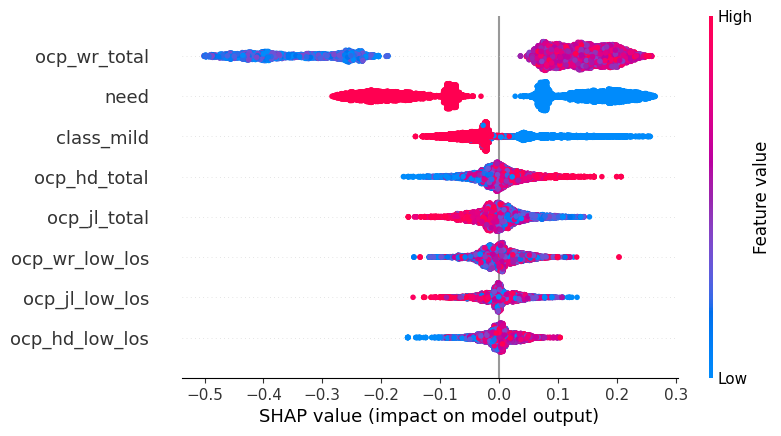

In [21]:
#pre_tuned
shap.plots.beeswarm(shap_values2[:,:,2])

All 3 placements

In [29]:
shap_as_list = []
for i in range(len(rf2.classes_)):
    shap_as_list.append(shap_values2.values[:,:,i])

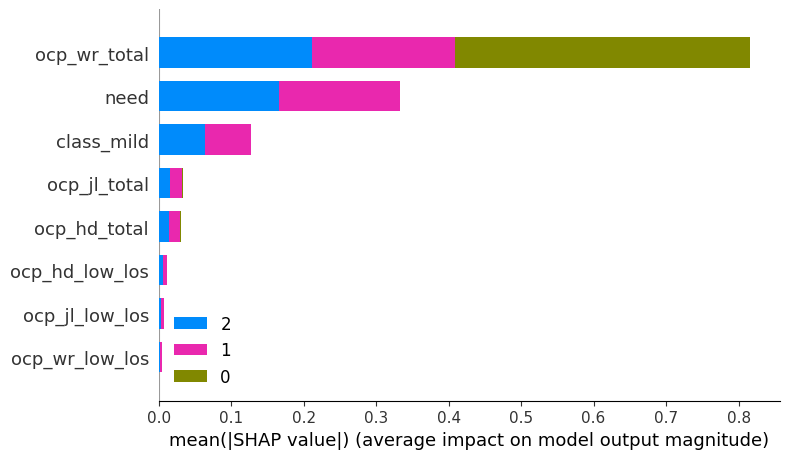

In [30]:
#tuned
shap.summary_plot(shap_as_list, X_train, plot_type="bar", class_names = rf2.classes_)

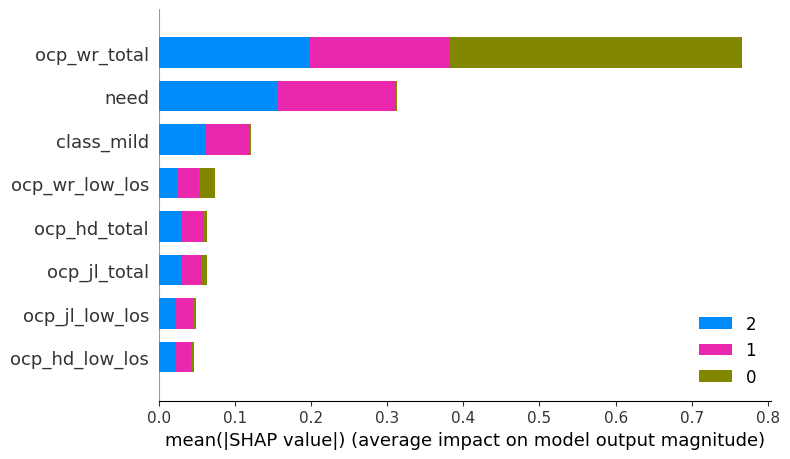

In [30]:
#pre_tuned
shap.summary_plot(shap_as_list, X_train, plot_type="bar", class_names = rf2.classes_)

## Data Progresison

<Axes: >

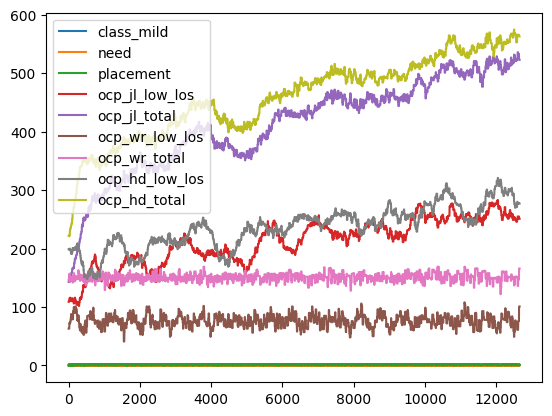

In [6]:
myDF.plot()